# Spider4SSC Dataset Analysis for Data in Brief

This notebook generates summary statistics and plots for the `DATA DESCRIPTION` section of the *Data in Brief* article.

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
import os

# Ensure the results directory exists
if not os.path.exists("./results"):
    os.mkdir("./results")

In [2]:
dev = json.load(open(f"data/Spider4SSC/dev.json"))
train = json.load(open(f"data/Spider4SSC/train.json"))
df_wide = {
    'dev': pd.DataFrame.from_records(dev),
    'train': pd.DataFrame.from_records(train)
}

print(f"Loaded {len(df_wide['dev'])} dev samples and {len(df_wide['train'])} train samples.")
print(f"Total samples: {len(df_wide['dev']) + len(df_wide['train'])}")
print("\nExample data structure (JSON keys):")
print(list(dev[0].keys()))

Loaded 608 dev samples and 3917 train samples.
Total samples: 4525

Example data structure (JSON keys):
['db_id', 'question', 'sql', 'sparql', 'cypher', 'namespaces', 'hardness']


In [3]:
# Melt dataframe to long format for easier analysis by language
df_list = []
for ds in ["dev", "train"]:
    melted_df = pd.melt(
        df_wide[ds],
        id_vars=['db_id', 'question'],
        value_vars=['sql', 'sparql', 'cypher'],
        var_name='query_language',
        value_name='query'
    )
    melted_df['split'] = ds
    df_list.append(melted_df)

df_long = pd.concat(df_list).reset_index(drop=True)

# Set query_language column as an ordered categorical
order = ['sparql', 'sql', 'cypher']
df_long['query_language'] = pd.Categorical(df_long['query_language'], categories=order, ordered=True)
df_long = df_long.sort_values('query_language')

## 2. Basic Dataset Statistics (for Table)

In [11]:
total_dbs = pd.concat([df_wide['train'], df_wide['dev']])['db_id'].nunique()

stats_data = {
    'Dev': [len(df_wide['dev']), df_wide['dev']['db_id'].nunique()],
    'Train': [len(df_wide['train']), df_wide['train']['db_id'].nunique()],
    'Total': [len(df_wide['dev']) + len(df_wide['train']), total_dbs]
}

df_stats = pd.DataFrame(stats_data, index=['Samples (Q/SQL/SPARQL/Cypher)', 'Unique Databases (db_id)'])
display(df_stats)

df_stats.to_csv("./results/dataset_statistics.csv")

,Dev,Train,Total
Samples (Q/SQL/SPARQL/Cypher),608,3917,4525
Unique Databases (db_id),20,139,159


## 4. Apply Analysis and Generate Stats Table

In [5]:
from dataset_analysis.analysis_helpers import (
    count_distinct_vars,
    count_keywords,
    count_joins_traversals,
    count_nesting_level2,
    count_filters,
    count_aggregations,
    count_sorting_limiting,
    count_projections,
    calculate_complexity_score,
    WEIGHTS
)

df_long['Distinct Variables'] = df_long.apply(count_distinct_vars, axis=1)
df_long['Tokens'] = df_long['query'].apply(lambda x: len(re.findall(r'\S+', x)))
df_long['Keywords'] = df_long.apply(count_keywords, axis=1)
df_long['Joins/Traversals'] = df_long.apply(count_joins_traversals, axis=1)
df_long['Nesting Depth'] = df_long.apply(count_nesting_level2, axis=1)
df_long['Filters'] = df_long.apply(count_filters, axis=1)
df_long['Aggregations'] = df_long.apply(count_aggregations, axis=1)
df_long['Sorting/Limiting'] = df_long.apply(count_sorting_limiting, axis=1)
df_long['Projections'] = df_long.apply(count_projections, axis=1)

weights = WEIGHTS
df_long['Complexity Score'] = df_long.apply(lambda row: calculate_complexity_score(row, weights), axis=1)


In [10]:
metrics = ['Tokens', 'Keywords', 'Joins/Traversals', 'Nesting Depth', 'Distinct Variables', 'Complexity Score']
df_desc = df_long.groupby('query_language')[metrics].describe().loc[:, (slice(None), ['mean', 'max'])]

pd.options.display.float_format = '{:,.2f}'.format
print("Descriptive Statistics of Query Metrics by Language (All Splits)")
display(df_desc.round(2))

df_desc.to_csv("./results/query_metrics_descriptive_stats_by_language.csv")


Descriptive Statistics of Query Metrics by Language (All Splits)


/tmp/ipykernel_989036/3773461881.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_desc = df_long.groupby('query_language')[metrics].describe().loc[:, (slice(None), ['mean', 'max'])]


Tokens       Keywords       Joins/Traversals        \
                 mean   max     mean   max             mean   max   
query_language                                                      
sparql          27.53 93.00     4.48 22.00             3.35 27.00   
sql             13.14 55.00     5.86 33.00             0.41  4.00   
cypher          12.68 30.00     6.16 20.00             0.40  4.00   

               Nesting Depth      Distinct Variables       Complexity Score  \
                        mean  max               mean   max             mean   
query_language                                                                
sparql                  1.00 1.00               3.71 10.00             2.89   
sql                     1.00 1.00               2.91 12.00             1.79   
cypher                  1.00 1.00               1.49  6.00             1.66   

                      
                 max  
query_language        
sparql         10.17  
sql             7.09  
cypher          4.35

## 5. Plotting Functions

In [7]:
import matplotlib
import seaborn as sns
from dataset_analysis.plot_utils import get_colors_bright


def set_style(font_scale=1.0, style_rc=None):
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    # Set the font to be serif, rather than sans
    # sns.set(font='serif')
    # sns.set(font_scale=font_scale)
    # if style_rc != None:
    sns.set(font='serif', font_scale=font_scale, rc=style_rc)
    # sns.set(font='serif', font_scale=font_scale)
    sns.set_style('whitegrid', {'axes.edgecolor': '.0', 'grid.linestyle': u'--',
                                'grid.color': '.8', 'xtick.color': '.15',
                                'xtick.minor.size': 3.0, 'xtick.major.size':
                                6.0, 'ytick.color': '.15', 'ytick.minor.size':
                                3.0, 'ytick.major.size': 6.0,
                                "font.family": "serif",
                                "font.serif": ["Times", "Palatino", "serif"]
                                # , "patch.linewidth":1.1
                                })
    matplot_colors = ["b", "g", "r", "c", "m", "y", "k", "w"]
    custom_colors = get_colors_bright()
    sns.set_palette(custom_colors)
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42



def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(round(100 * y))
    
    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

formatter = FuncFormatter(to_percent)


def plot_bars(df, y_list, split: str, order=None, grid_size=(2, 2), ymax=None, ylab="Number"):
    set_style(font_scale=1.2)
    
    f, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 8))
    if grid_size == (1, 1):
        axs = np.array([axs]) # Make it iterable
    axs = axs.flatten()
        
    i = 0
    hue_order = sorted(df["query_language"].unique())
    if order is None:
        order = hue_order
        
    for y in y_list:
        axs_i = axs[i]
        sns.barplot(x="query_language", hue="query_language", y=y, data=df, ax=axs_i,
            errorbar=None, order=order, hue_order=hue_order, palette=get_colors_bright().tolist())
        axs_i.set_title(f"{y} ({split})")
        axs_i.set_xlabel('')
        if ymax is not None:
            try: 
                ym = ymax[i]
            except TypeError:
                ym = ymax
            axs_i.set_ylim(0, ym)
        
        # Set Y-label only for the first column
        if i % grid_size[1] == 0:
            axs_i.set_ylabel(ylab)
        else:
            axs_i.set_ylabel('')

        i+=1
    
    # Hide any unused subplots
    for j in range(i, len(axs)):
        axs[j].set_visible(False)
        
    f.tight_layout()
    return f

In [8]:
custom_colors = get_colors_bright()
sns.set_palette(custom_colors[4:])

## 6. Generate and Save Plots

Generating plots for dev split...
Generating plots for train split...


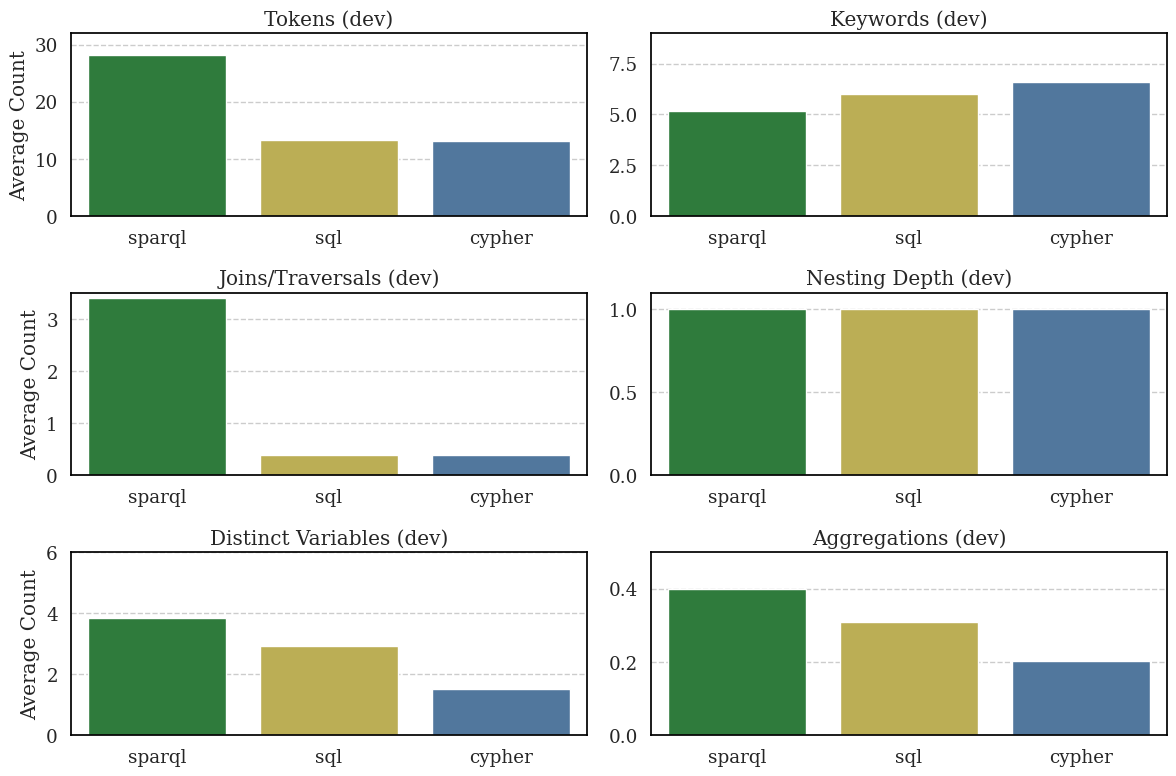

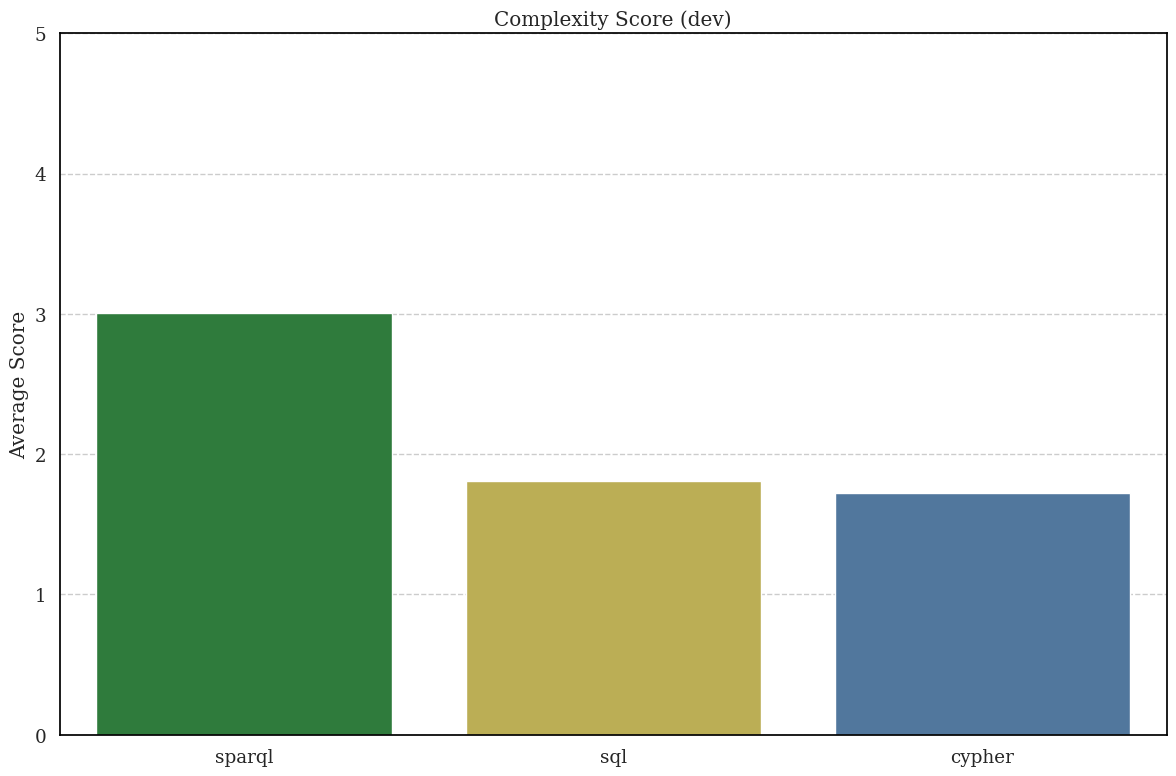

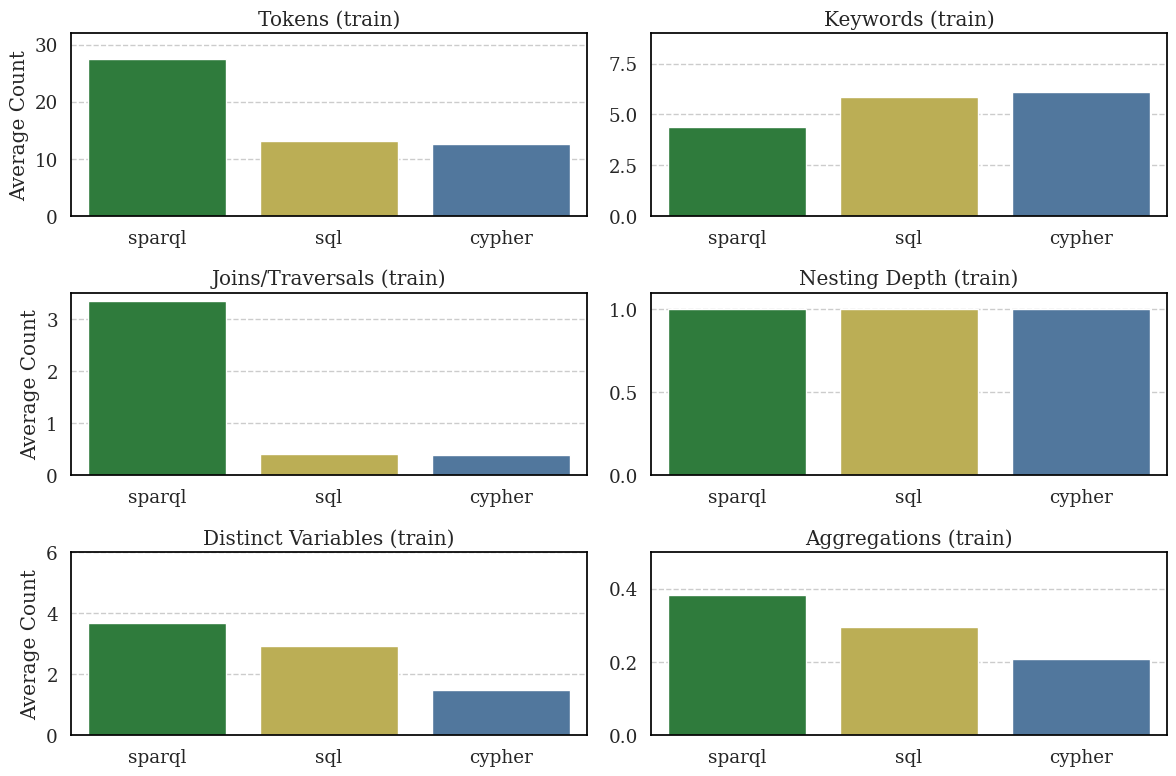

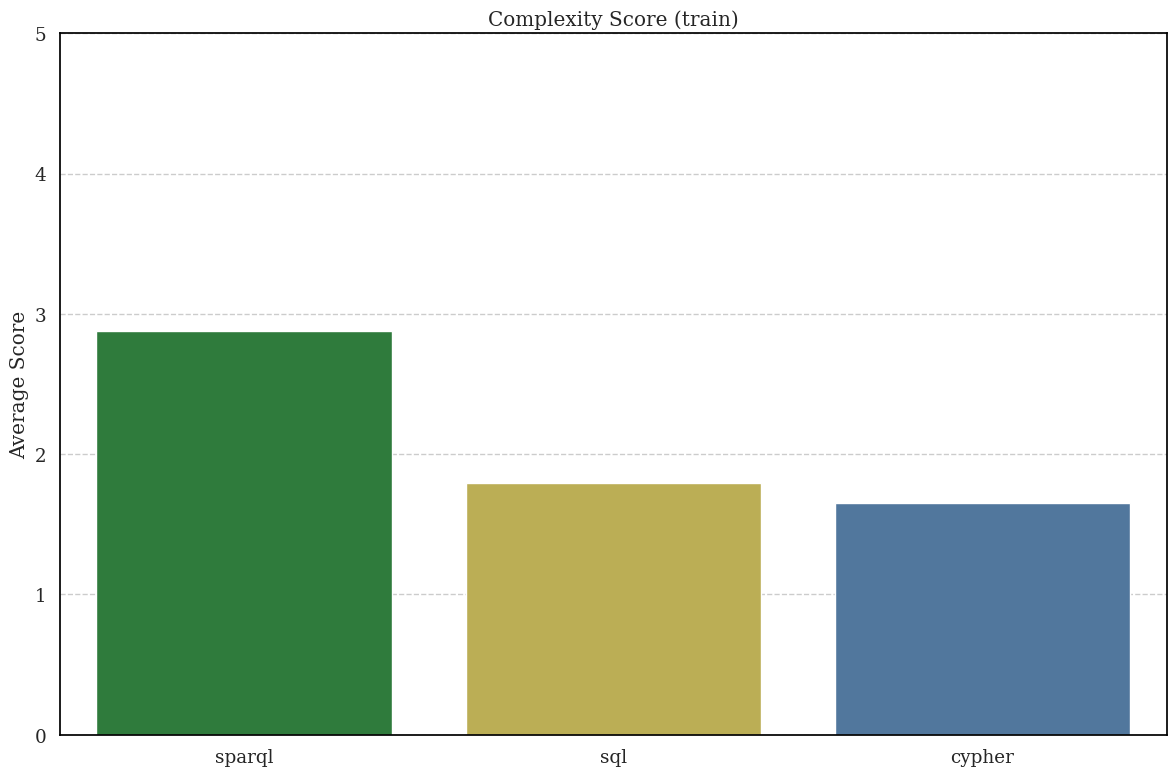

In [9]:
metrics_to_plot = ["Tokens", "Keywords", "Joins/Traversals", "Nesting Depth", "Distinct Variables", "Aggregations"]
ylab = "Average Count"
ymx = [32, 9, 3.5, 1.1, 6, 0.5] # Adjusted y-max values for clarity
order = ['sparql', 'sql', 'cypher'] # Set custom order for plots

for ds in ['dev', 'train']:
    print(f"Generating plots for {ds} split...")
    df_split = df_long[df_long['split'] == ds]
    f = plot_bars(df_split, y_list=metrics_to_plot, 
                  split=ds, grid_size=(3,2), ymax=ymx, ylab=ylab, order=order)
    
    f.savefig(f"results/SSC-{ds}_complexity-metrics.svg", bbox_inches='tight')
    f.savefig(f"results/SSC-{ds}_complexity-metrics.png", dpi=200, bbox_inches='tight')

    # Also plot the single complexity score
    f_comp = plot_bars(df_split, y_list=["Complexity Score"], 
                       split=ds, grid_size=(1, 1), ymax=5.0, ylab="Average Score", order=order)
    
    f_comp.savefig(f"results/SSC-{ds}_complexity-score.svg", bbox_inches='tight')
    f_comp.savefig(f"results/SSC-{ds}_complexity-score.png", dpi=200, bbox_inches='tight')

